# Example classification: Database Australian Credit Card

In this example it will show how to work the library **deepensemble**. 

## Data

This database corresponds to a credit card application problem, seen as a classification problem where the classes correspond to whether the request is accepted or not. The database has 690 samples, 307 (44.5%) for accepted application and 383 (55.5%) for non-accepted request. Each sample contains 14 features that are normalized to the $ [0, 1] $ range, the original features are continuous and nominal with different amounts of categories making it an interesting problem because of the variety of feature types.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

from config_test import *

from sklearn import model_selection
from matplotlib.pyplot import *
from theano import shared, config
import numpy as np

from deepensemble.metrics import *
from deepensemble.utils import *


data_input, data_target, classes_labels, name_db, desc, col_names = \
    load_data('australian_scale', data_home='../../test_models/data', normalize=False)

# Generate testing and training sets
input_train, input_test, target_train, target_test = \
    model_selection.train_test_split(data_input, data_target, test_size=0.3)

## Define parameters of models and training

In [2]:
n_features = data_input.shape[1]
n_classes = len(classes_labels)

n_output = n_classes
n_inputs = n_features

n_neurons_model = int(0.75 * (n_output + n_inputs))

n_ensemble_models = 4
fn_activation1 = ActivationFunctions.sigmoid
fn_activation2 = ActivationFunctions.sigmoid

y = get_index_label_classes(translate_target(data_target, classes_labels))
s = ITLFunctions.silverman(shared(np.array(y))).eval()

list_scores = [
    {'fun_score': mutual_information_parzen, 'name': 'Información Mutua'},
    {'fun_score': mutual_information_cs, 'name': 'QMI CS'},
    {'fun_score': mutual_information_ed, 'name': 'QMI ED'}
]

print('Silverman: %0.4g' % s)

batch_size = 32
max_epoch = 500

update_fn=sgd
name_update='SGD'

args_train_cip = {'max_epoch': max_epoch, 'batch_size': batch_size, 'early_stop': False,
              'improvement_threshold': 0.995, 'update_sets': True, 'minibatch': True,
              'criterion_update_params': 'cost', 'maximization_criterion': True}

Silverman: 0.4882


## Training Ensemble CIPL

This ensemble has {{n_ensemble_models}} MLP networks, where each MLP net has {{n_neurons_model}} neurons in hidden layer and the output is a vector with {{n_output}} elements that represent each class (**one hot encoding**). The cost function is **CIPL** (Cross Informartion Potential Learning) and the update funtion is **SGD** (learning rate $\eta=-0.03$). The parameters of **CIPL** are $\beta=0.1$ and $\lambda=0.5$.

In [3]:
# Create Ensemble CIP
ensembleCIP = get_ensembleCIP_model(name='Ensamble CIPL', classification=True, classes_labels=classes_labels,
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    is_cip_full=False,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='CS',
                                    beta=0.1, lamb=0.5, s=s,
                                    lsp=1.0, lsm=0.5,
                                    lr=0.001,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=True,
                                    update=update_fn, name_update=name_update,
                                    list_scores=list_scores,
                                    params_update={'learning_rate': -0.03})

metrics_ensembleCIP = FactoryMetrics.get_metric(ensembleCIP)
# Compile
ensembleCIP.compile(fast=False)                   
# training
metrics = ensembleCIP.fit(input_train, target_train, **args_train_cip)
print("FINISHED!")
# Compute metricstrain
metrics_ensembleCIP.append_metric(metrics)

Comienza la compilación Ensamble CIPL  - elapsed: 15.18 [s]
Ensamble CIPL - fold: 1, epoch:[####################] 500/500 elapsed: 27.32[s] - left: 0.00[s] | score: 0.8630 / 0.81258
FINISHED!


<IPython.core.display.Javascript object>


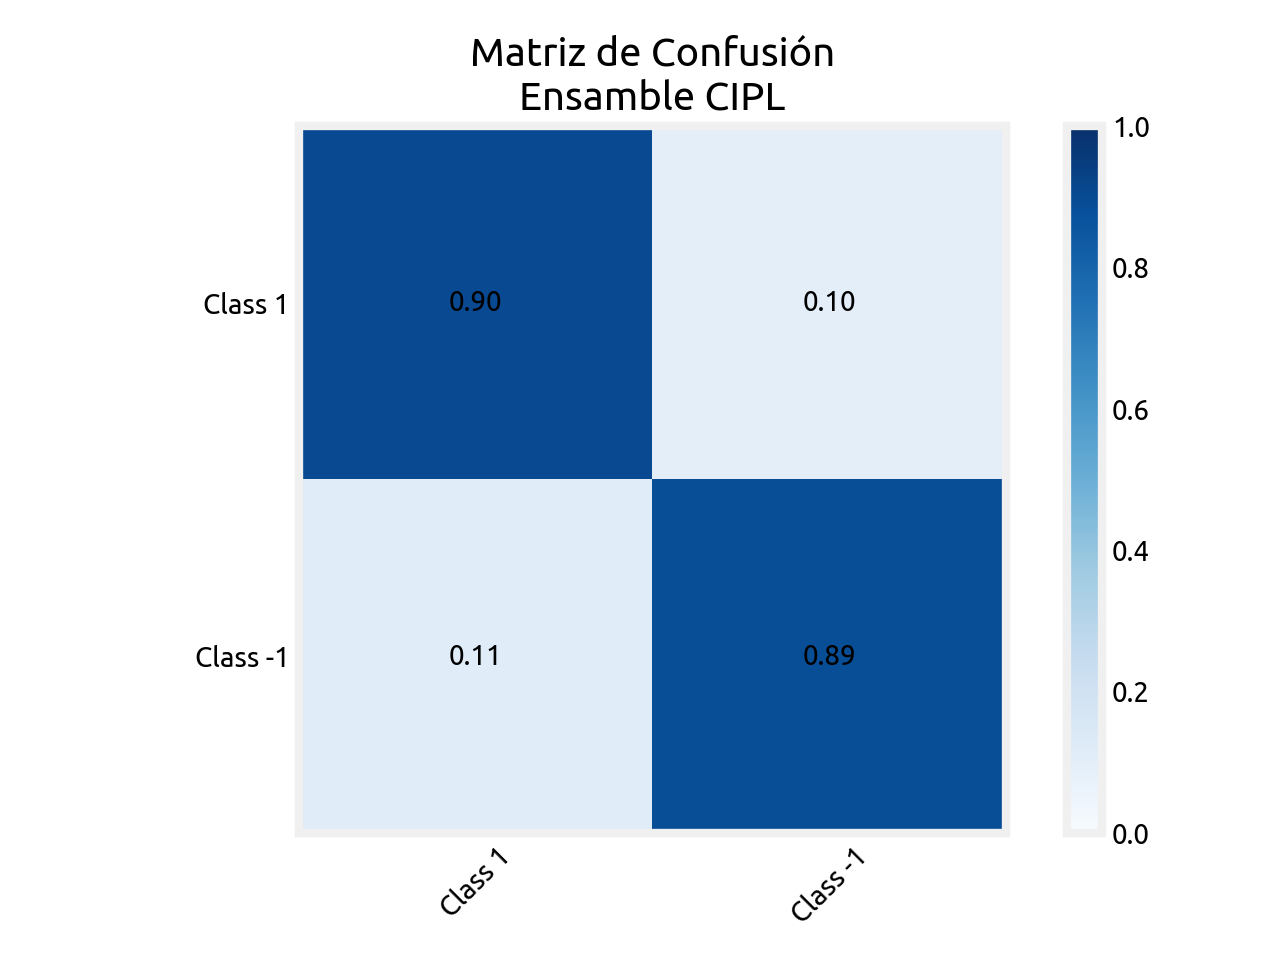

Classification Report:
----------------------------------------------------------------------------
           Precision  Recall     f1 Score   Support    
----------------------------------------------------------------------------
Class 1    90.00 +-0.00      90.00 +-0.00      90.00 +-0.00      110               
Class -1   88.66 +-0.00      88.66 +-0.00      88.66 +-0.00      97                
----------------------------------------------------------------------------
average:   89.37 +-0.00      89.37 +-0.00      89.37 +-0.00      
----------------------------------------------------------------------------



In [4]:
metrics_ensembleCIP.append_prediction(input_test, target_test, append_last_pred=True)
metrics_ensembleCIP.plot_confusion_matrix(title='Matriz de Confusión\nEnsamble CIPL')
plt.show()

metrics_ensembleCIP.classification_report()

## Plot Scores functions of Ensemble CIPL training

<IPython.core.display.Javascript object>


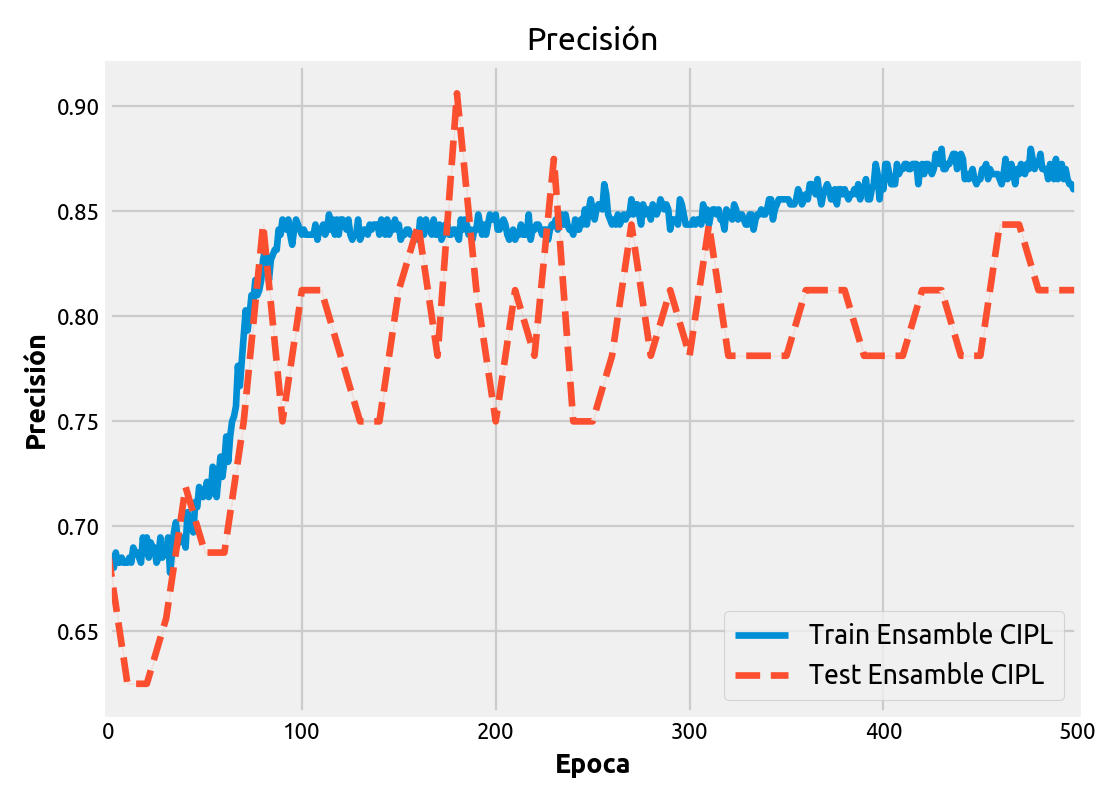

<IPython.core.display.Javascript object>


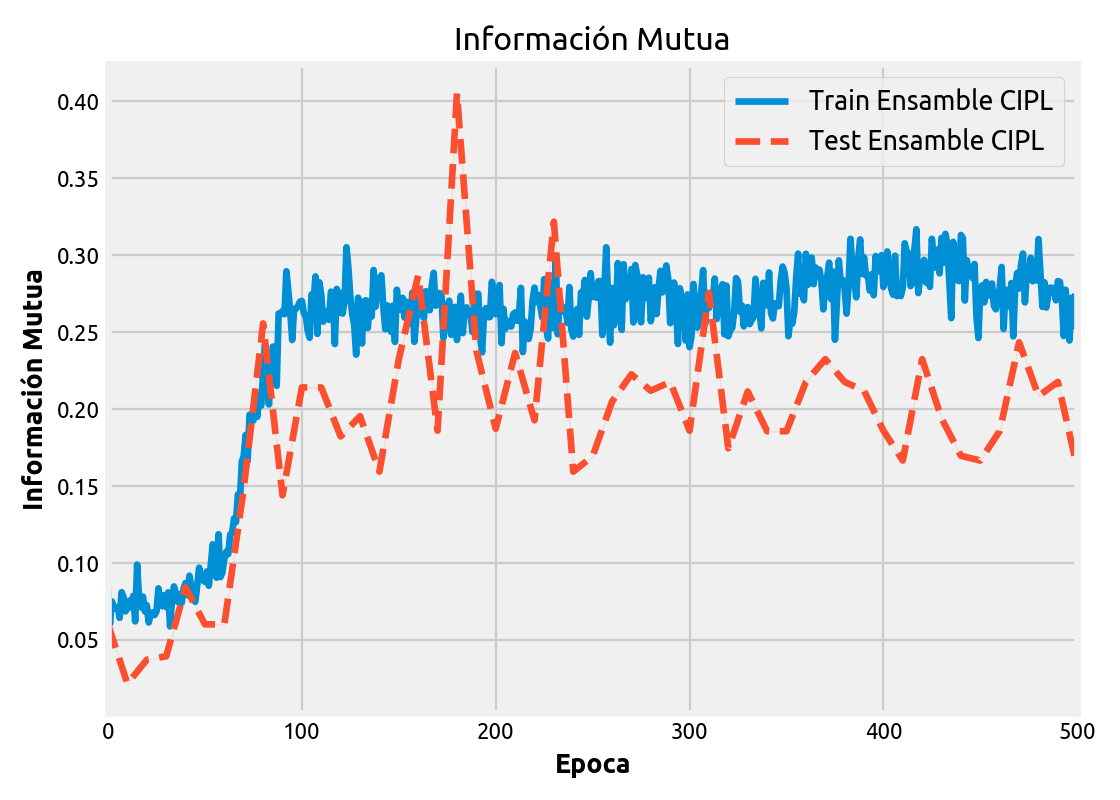

<IPython.core.display.Javascript object>


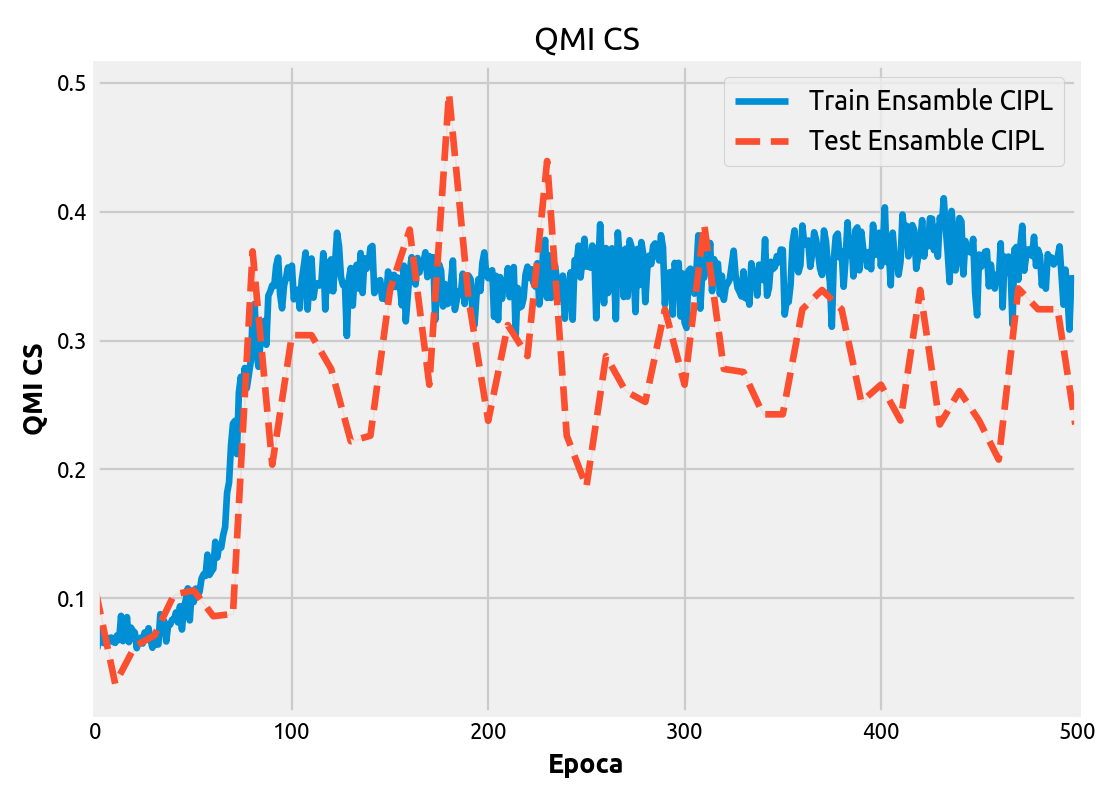

<IPython.core.display.Javascript object>


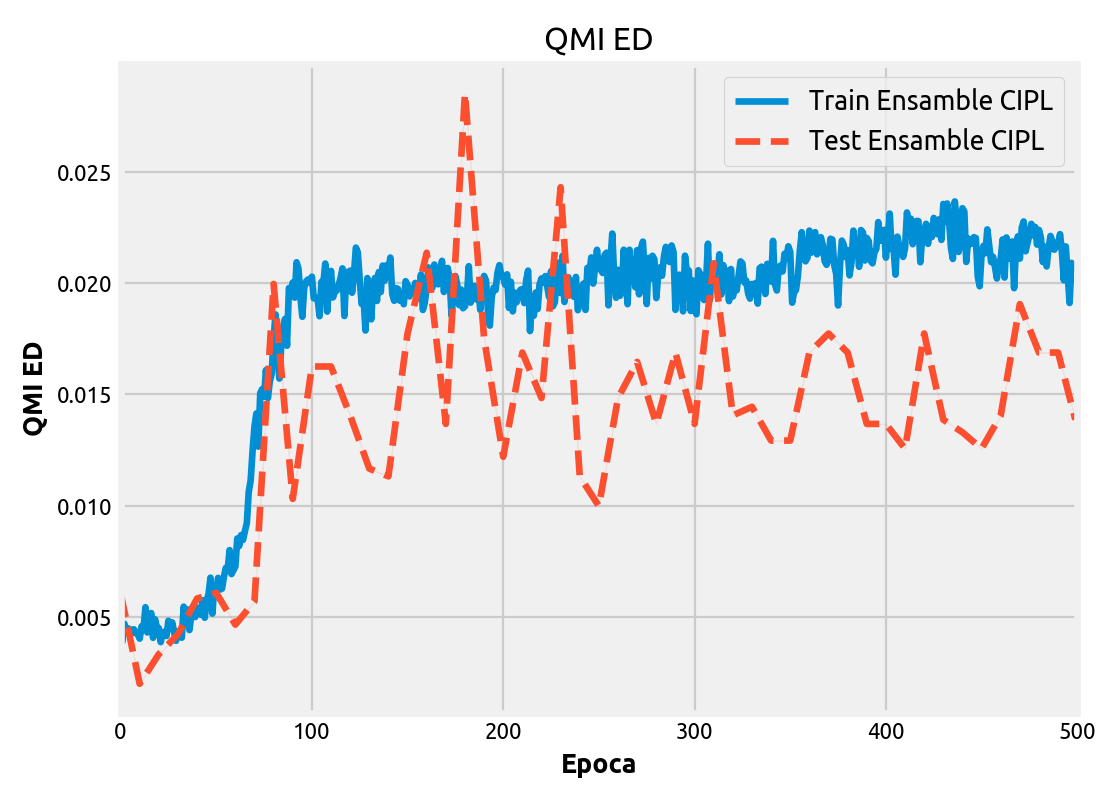

In [5]:
metrics_ensembleCIP.plot_scores(max_epoch=max_epoch, title='')

plt.show()